In [1]:
!pip install nltk

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 35.3 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [7]:
import os
import torch
import time
import json
import pandas as pd
import nltk
from nltk.tokenize import sent_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, pipeline
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
# import pandas as pd
import re
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/jovyan/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [2]:
folder_path = "Transcripts"
for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    if os.path.isfile(file_path) & filename.endswith(".csv"):
        print(f"\nProcessing file: {filename}")
        input_data = pd.read_csv(file_path, sep=None, engine='python')
        print(f"\nFile Loaded!")
input_data        


Processing file: adg0001_er_2024_10_31.csv

File Loaded!


,Band,Timecode,Sprecher,Transkript,Übersetzung,Hauptüberschrift,Zwischenüberschrift,Hauptüberschrift (Übersetzung),Zwischenüberschrift (Übersetzung),Registerverknüpfungen,Anmerkungen,Anmerkungen (Übersetzung)
0,1,00:00:06.00,INT_AH,Können wir anfangen?,NaN,"Haushalt und Hausarbeit, Lebenslauf, Arbeit (a...",NaN,NaN,NaN,90443688#90443736#90443668,NaN,NaN
1,1,00:00:06.00,INT_AH,"Also wäre schön, wenn Sie mit Kindheit beginne...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,00:00:12.00,IP_FA,"Ich war das erste Enkelkind, einzige Enkelkind...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,00:00:16.00,IP_FA,Ich bin gebürtig aus Hemer im Sauerland und bi...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,00:00:43.00,IP_FA,"Und, ja, Kindheit verlief eigentlich an und fü...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
717,1,01:11:30.00,IP_FA,"Man hat gedacht, nö, guck mal, so kann’s ..., ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
718,1,01:11:35.00,IP_FA,Vor allen Dingen wenn man so wie ich groß gewo...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
719,1,01:11:40.00,IP_FA,"Ich mein, ich bin zwar immer schon so veranlag...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
720,1,01:11:42.00,IP_FA,EINGEFÜGT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
transcript_text = " ".join(input_data["Transkript"].dropna().astype(str))

In [4]:
def split_into_paragraphs(text, sentences_per_paragraph=10):
    """
    Splits the text into paragraphs containing a fixed number of sentences.
    """
    sentences = sent_tokenize(text)
    paragraphs = []
    for i in range(0, len(sentences), sentences_per_paragraph):
        paragraphs.append(" ".join(sentences[i:i+sentences_per_paragraph]))
    return paragraphs

split_into_paragraphs(transcript_text)

['Können wir anfangen? Also wäre schön, wenn Sie mit Kindheit beginnen würden. Ich war das erste Enkelkind, einzige Enkelkind, lange Zeit und bin sehr verwöhnt worden, da ich ziemlich viel bei der Großmutter gewesen bin. Ich bin gebürtig aus Hemer im Sauerland und bin 29.5.25 geboren. Und, ja, Kindheit verlief eigentlich an und für sich normal, habe allerdings ziemlich unter Migräne zu leiden gehabt schon als Vorschulkind, was sich während der Schulzeit verschlechterte und verschlimmerte. Ich hätte gerne die höhere Schule besucht, durfte aber nicht, weil mir immer gesagt wurde, ich sei krank. Die Schulentlassung, also den Hauptschulabschluss, habe ich gemacht 1939. Und damals war das Pflichtjahr bzw. Haushaltsjahr, eh,  musste gema…, musste gemacht werden, ob man die Schule, äh, besuchte oder bevor man den Beruf ergreifen konnte, so. Und da meine Großeltern ziemlich, sagen wir mal, einen kleinen Dünkel hatten, durfte ich nicht in einen Einzelhaushalt, wie das üblich war, daher kam ich 

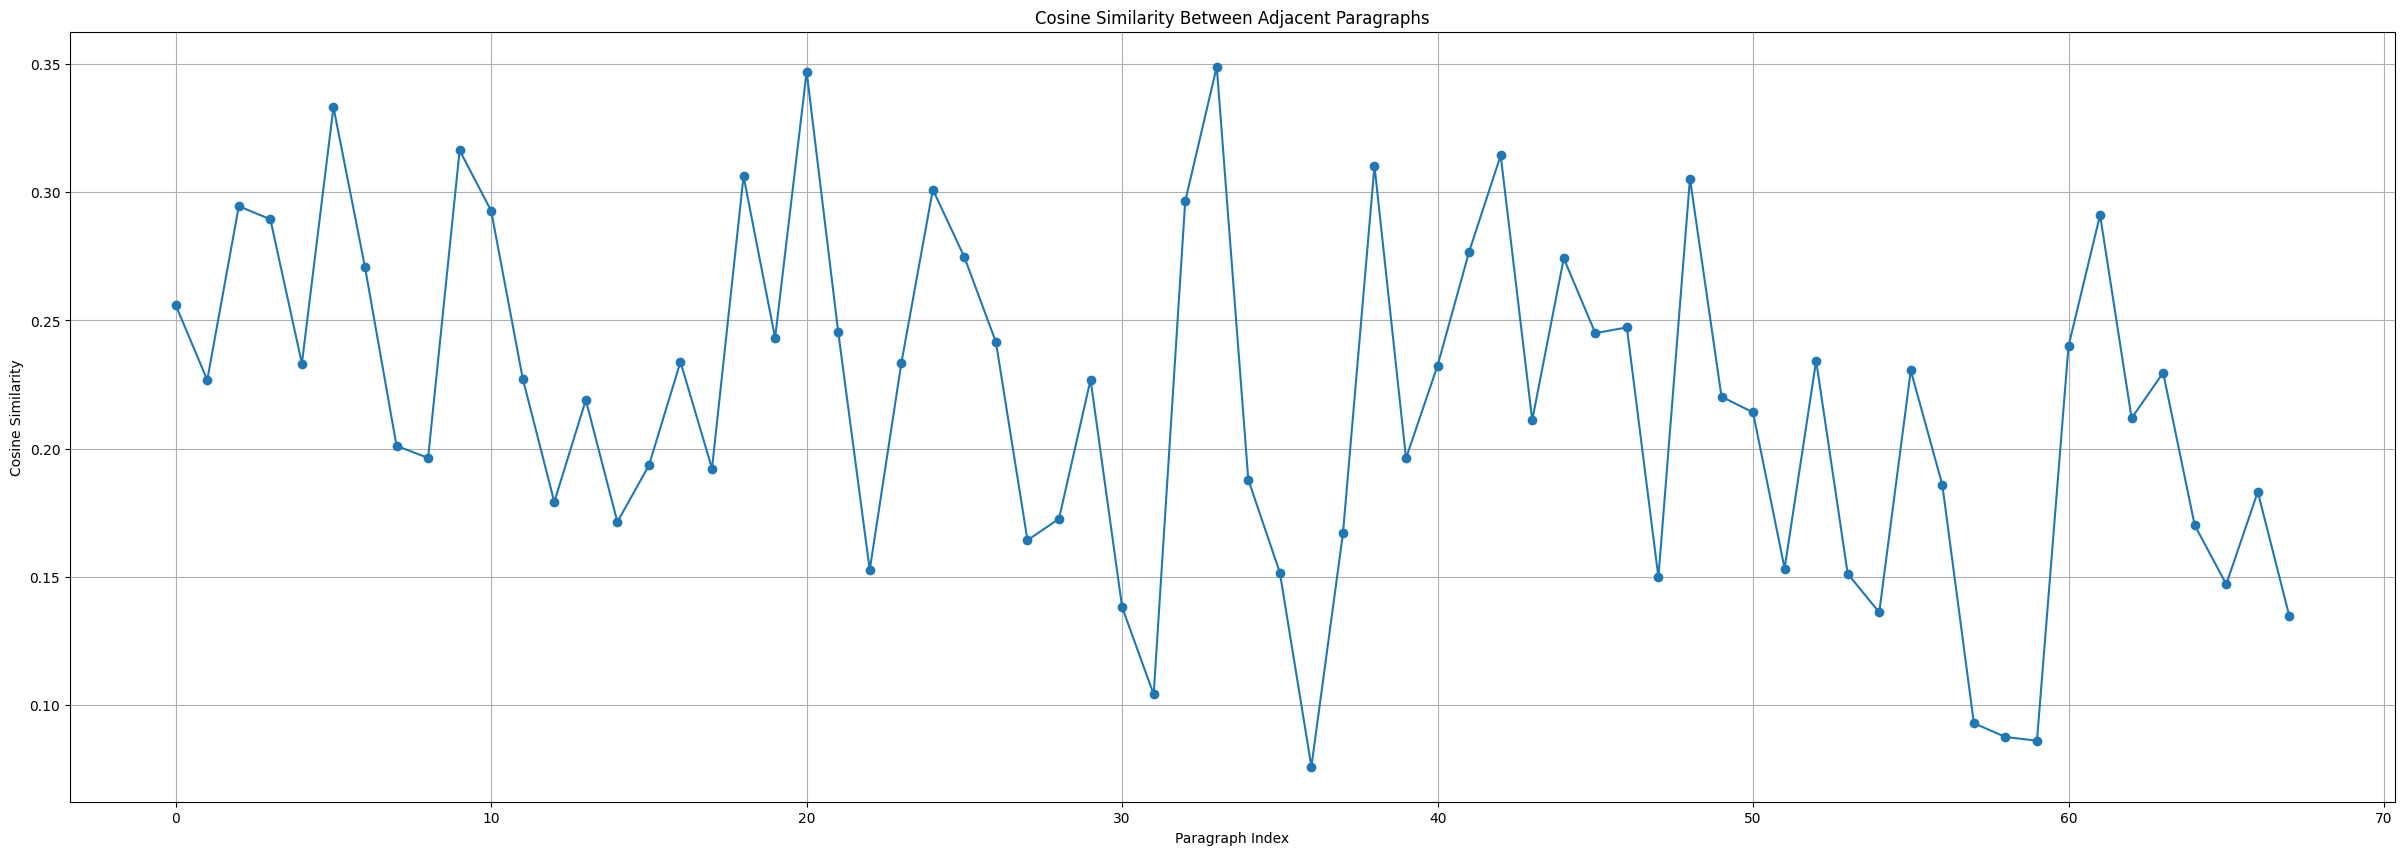

Boundaries: [0, 2, 5, 9, 13, 15, 18, 20, 23, 28, 32, 37, 40, 44, 46, 48, 52, 55, 60, 63, 66, 69]


,Segment
0,"Können wir anfangen? Also wäre schön, wenn Sie..."
1,Denn Haushaltsarbeit war ja auch im Lager selb...
2,"Nein, nach dem Landjahr. Das war 1940. Und hab..."
3,Der Vater war Fabrikant. War auch verwöhnt. Wi...
4,"Sie war schwer zu schätzen, ne. Ich hab auch l..."
5,"Schon alleine die Wäsche, denn früher gab’s ja..."
6,Das hat mir unwahrscheinlich viel Spaß gemacht...
7,Der wurde jeden Tag festgelegt. Der hing dann ...
8,Wir korrespondierten ja auch mit Soldaten. Jed...
9,"Ja, das war, das war dann, eh … Oder Ende 43? ..."


In [9]:
def segment_text_by_local_minima(text, sentences_per_paragraph=10):
    """
    Segments a transcript into chunks by detecting local minima in cosine similarity
    between adjacent paragraphs. Returns a DataFrame with one column 'Segment'
    containing each segment's text.
    """
    # Split text into paragraphs
    paragraphs = split_into_paragraphs(text, sentences_per_paragraph)
    
    # If there's only one paragraph, return it as the only segment
    if len(paragraphs) <= 1:
        return pd.DataFrame({"Segment": [text]})
    
    # Vectorize paragraphs using TF-IDF
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(paragraphs)
    
    # Compute cosine similarity between consecutive paragraphs
    similarities = []
    for i in range(tfidf_matrix.shape[0] - 1):
        sim = cosine_similarity(tfidf_matrix[i], tfidf_matrix[i+1])[0][0]
        similarities.append(sim)

    
    # Plot the similarity scores
    plt.figure(figsize=(30, 10))
    plt.plot(similarities, marker='o')
    plt.xlabel('Paragraph Index')
    plt.ylabel('Cosine Similarity')
    plt.title('Cosine Similarity Between Adjacent Paragraphs')
    plt.grid(True)
    plt.show()
    
    # Identify local minima: where the similarity is less than its immediate neighbors
    boundaries = [0]  # starting index of first segment
    for i in range(1, len(similarities) - 1):
        if similarities[i] < similarities[i-1] and similarities[i] < similarities[i+1]:
            boundaries.append(i + 1)
    boundaries.append(len(paragraphs))  # end boundary
    print("Boundaries:", boundaries)
    
    # Build segments from boundaries
    segments = []
    for start, end in zip(boundaries, boundaries[1:]):
        segment_text = " ".join(paragraphs[start:end])
        segments.append(segment_text)
    
    return pd.DataFrame({"Segment": segments})
segment_text_by_local_minima(transcript_text)